Dans ce notebook ensemble voting sur lr, randomforest et lgbm optimisés précédament

    * chargement du pipeline avec les 3 modèles et l'estimateur final

    * optimisation des poids de l'estimateur final
    
    * évaluation de l'ensemble
    
    * enregistrement pour dashboard




WORK IN PROGRESS

finaliser le score sut test dans funstions.py

changer lea affichages de scores par mean +- std

recuperer les scores depuis run à la fin pour faire un tableau de scores identique à celui de voting mais dans les 3 autres notebooks

# Imports

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
pd.set_option('display.max_row', 244)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go


# misc libaries
import missingno as msno
bleu = (70 / 255, 130 / 255, 180 / 255)
# import dataprep.eda as eda
import qgrid

# File system manangement
import os
import joblib 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport Functions
from Functions import *

Loading functions


In [3]:
# CONSTANTS

ITERATIONS = 10

JOBS = 1

EDA = 'EDA 1-7 all features_aggregated'


LOG = True

RESUME = True
ID_RUN = 'PROJ-30'

# Log experiment to Neptune.ai

In [4]:
import neptune.new as neptune
# import neptunecontrib.monitoring.optuna as opt_utils
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

if LOG:
    NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkOTQ1YmNhNS1hZDYyLTRlYzQtYWU0Zi0xMjY0Yjg1MzBiMzEifQ=="
    # log to Neptune
    if RESUME:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07',
                           run=ID_RUN) # your credentials
    else:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07') # your credentials
        

    neptune_callback = optuna_utils.NeptuneCallback(run,
                                                    plots_update_freq=10,
                                                    log_plot_param_importances=True)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/m.leroy975/Projet07/e/PROJ-30
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Chargement des données




In [5]:
# local run
path='FEATURES/'
features = joblib.load ( path+EDA+'.feat')

# Kaggle run
# path='../input/projet-07/' 
# features = joblib.load ( path+EDA+'.feat')

if LOG:
    # Name and hash of experiment features
    run['Data/Version/Features'].log(EDA)
    run['Data/Version/Features hash'].log(pd.util.hash_pandas_object(features))

Vérification du chargement

<AxesSubplot:>

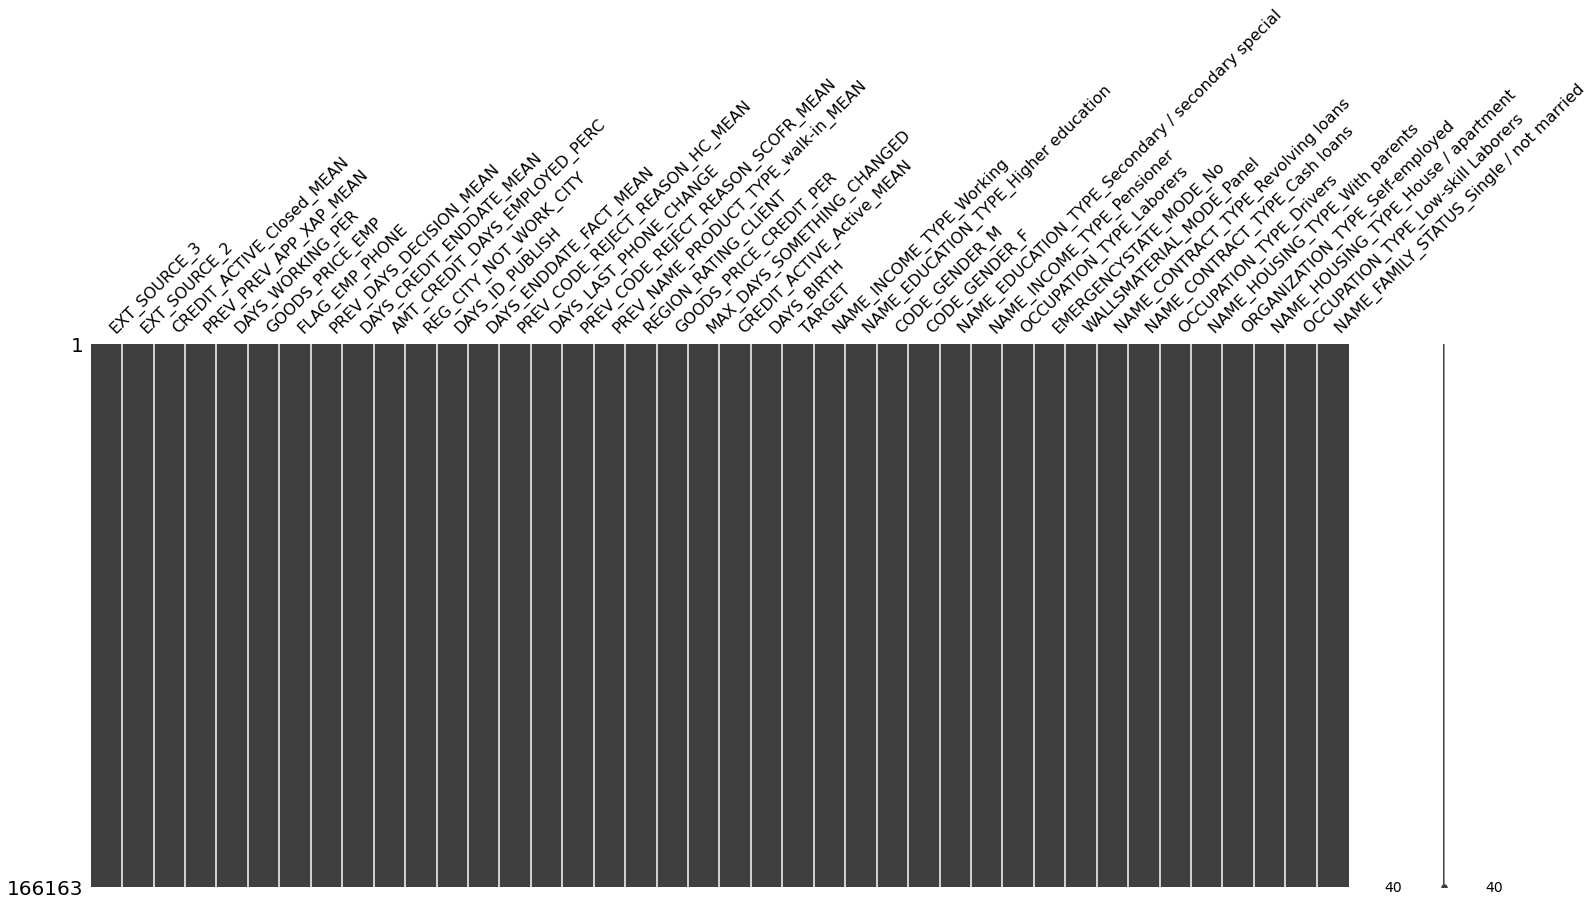

In [6]:
msno.matrix(features)

In [7]:
# Features overwiew
from collections import Counter

display(features)
print('Features shape {} x {}'.format(features.shape[0],features.shape[1]))
# TARGET ration on whole dataset
print('TARGET ratio {:.8%}'.format(features.TARGET.value_counts()[1]/features.TARGET.value_counts()[0]) )
print(Counter(features.TARGET))

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_PREV_APP_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.262949,0.750000,1.00,0.067329,0.001815,1,-606.000000,-349.000000,-0.001567,0,-2120,-697.500000,0.00,-1134.0,0.0,0.00,2,1.158397,-637.0,0.250000,-9461,1,1,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1
100004,0.729567,0.555912,1.000000,1.00,0.011814,0.001667,1,-815.000000,-488.500000,-0.001667,0,-2531,-532.500000,0.00,-815.0,0.0,0.00,2,1.000000,-225.0,0.000000,-19046,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1
100008,0.621226,0.354225,0.666667,1.00,0.093737,0.003494,1,-1192.000000,-391.333333,-0.003238,0,-477,-909.000000,0.00,-2536.0,0.0,0.00,2,1.079198,-477.0,0.333333,-16941,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
100009,0.492060,0.724000,0.777778,1.00,0.227174,0.002244,1,-719.285714,-794.937500,-0.002005,0,-619,-1108.500000,0.00,-1562.0,0.0,0.00,2,1.118800,-619.0,0.222222,-13778,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
100010,0.540654,0.714279,0.500000,1.00,0.023820,0.000293,1,-1070.000000,-119.500000,-0.000293,1,-2379,-1138.000000,0.00,-1070.0,0.0,0.00,3,1.000000,-449.0,0.500000,-18850,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456246,0.735221,0.313334,0.666667,1.00,0.543859,0.038827,1,-897.000000,-234.666667,-0.038827,1,-4531,-1331.000000,0.00,-1516.0,0.0,0.00,2,1.000000,-4531.0,0.333333,-16063,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0
456247,0.609276,0.501221,0.727273,0.80,0.033614,0.001612,1,-1387.800000,1449.818182,-0.001155,0,-3936,-1085.000000,0.20,-2315.0,0.0,0.00,2,1.396000,-399.0,0.272727,-11870,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
456253,0.218859,0.535722,0.500000,1.00,0.529266,0.013540,1,-2380.000000,280.500000,-0.011689,1,-5150,-794.000000,0.00,-1909.0,0.0,0.00,3,1.158400,-5150.0,0.500000,-14966,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0


Features shape 166163 x 40
TARGET ratio 8.55218459%
Counter({0: 153072, 1: 13091})


In [8]:
# Descriptive Statistics of features
features.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_PREV_APP_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
count,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.00000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000
mean,0.510259,0.522641,0.653382,0.862464,0.167314,0.007263,0.999958,-960.526239,530.347564,-0.006515,0.269284,-2930.141831,-948.384656,0.061699,-1068.938759,0.005888,0.081658,2.055151,1.121981,-1432.243454,0.342889,-15032.930021,0.078784,0.634377,0.268225,0.363884,0.636116,0.687837,0.000048,0.217287,0.525767,0.21784,0.093137,0.906863,0.072525,0.052081,0.142926,0.883241,0.006927,0.136553
std,0.194887,0.186316,0.224895,0.197720,0.138020,0.011067,0.006490,568.589438,2591.832795,0.009935,0.443589,1485.695073,512.261883,0.133157,825.088565,0.043194,0.177448,0.499676,0.124815,1181.057628,0.223962,3555.417425,0.269402,0.481606,0.443036,0.481117,0.481117,0.463377,0.006939,0.412401,0.499337,0.41278,0.290626,0.290626,0.259356,0.222192,0.349998,0.321134,0.082940,0.343376
min,0.000527,0.000010,0.000000,0.000000,0.000042,0.000002,0.000000,-2922.000000,-28039.000000,-0.256178,0.000000,-7197.000000,-2884.000000,0.000000,-4173.000000,0.000000,0.000000,1.000000,0.150000,-6226.000000,0.000000,-25200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370650,0.411550,0.500000,0.750000,0.061776,0.001720,1.000000,-1297.000000,-711.000000,-0.007465,0.000000,-4239.000000,-1269.500000,0.000000,-1684.000000,0.000000,0.000000,2.000000,1.000000,-2094.000000,0.187500,-17721.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.537070,0.573477,0.666667,1.000000,0.130265,0.003899,1.000000,-845.375000,-197.000000,-0.003506,0.000000,-3076.000000,-916.000000,0.000000,-929.000000,0.000000,0.000000,2.000000,1.118800,-1094.000000,0.333333,-14834.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.667458,0.666053,0.800000,1.000000,0.234367,0.008310,1.000000,-512.422619,505.950000,-0.001541,1.000000,-1696.000000,-565.633333,0.000000,-376.000000,0.000000,0.083333,2.000000,1.198000,-495.000000,0.500000,-12168.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.885488,0.855000,1.000000,1.000000,0.728811,0.256178,1.000000,-2.000000,31186.000000,-0.

# SPLITTING

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(features,
                               test_size=.20,
                               random_state=42,
                               shuffle=True,
                               stratify=features.TARGET)

train_true = train.pop('TARGET')
print('train',train.shape)
print('TARGET=1 ratio on train {:.8%}'.format(train_true.value_counts()[1]/train_true.value_counts()[0]) )
test_true = test.pop('TARGET')
print('test',test.shape)
print('TARGET=1 ratio on test {:.8%}'.format(test_true.value_counts()[1]/test_true.value_counts()[0]))

train (132930, 39)
TARGET=1 ratio on train 8.55238982%
test (33233, 39)
TARGET=1 ratio on test 8.55136371%


In [10]:
if LOG:
    run['Data/Version/Train shape'].log(str(train.shape))
    run['Data/Version/Train target ratio'].log(train_true.value_counts()[1]/train_true.value_counts()[0])
    run['Data/Version/Test shape'].log(str(test.shape))
    run['Data/Version/Test target ratio'].log(test_true.value_counts()[1]/test_true.value_counts()[0])

# Chargement du modèle voting

In [11]:
voting = joblib.load ('Models/voting_classifier.mod')
display(voting.get_params(deep=False))
if LOG:
    # Name and hash of experiment features
    run['Modele/Name'] = 'Voting Classifier'

{'estimators': [('lr',
   Pipeline(steps=[('over',
                    RandomOverSampler(random_state=42,
                                      sampling_strategy=0.12496392540669532)),
                   ('under',
                    RandomUnderSampler(random_state=42,
                                       sampling_strategy=0.24875704537691895)),
                   ('scaler', RobustScaler(unit_variance=True)),
                   ('model',
                    LogisticRegression(C=387.7896540335958,
                                       class_weight='balanced', max_iter=5000,
                                       n_jobs=-1, random_state=42,
                                       tol=2.4770441141413036e-05))])),
  ('rf',
   Pipeline(steps=[('over',
                    RandomOverSampler(random_state=42,
                                      sampling_strategy=0.12356267384192812)),
                   ('under',
                    RandomUnderSampler(random_state=42,
                      

###  Metrics¶

In [12]:
from sklearn.metrics import  confusion_matrix, make_scorer, roc_auc_score
 #accuracy_score,f1_score,fbeta_score,hamming_loss,log_loss,zero_one_loss
# TN_value = 2  ; FN_value = -5
# FP_value = -60  ; TP_value = 24


# Cost weight
tn_cost = 2  ; fn_cost = -5
fp_cost = -6  ; tp_cost = 1

penalty = np.array([tn_cost,fn_cost,fp_cost,tp_cost])

# cost function
def cost(y,y_pred):
    cm = confusion_matrix(y,y_pred,normalize='true')
#     print(cm)

#     return  sum( cm.reshape(-1)*penalty)
    return  (sum( cm.reshape(-1)*penalty)+11)/14

SCORER = {'AUC' : 'roc_auc', 'COST' : make_scorer(cost)}

## Optimisation des poids

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

## Recherche de la combinaison optimale

In [14]:
### fonction to maximize
from sklearn.model_selection import cross_validate
from sklearn.base import clone

def Opt_search(trial):
    # the function gets a set of variable parameters in "param"
    # we use theses params to set pipeline params
    
    # Initialize params
    params = {}
    trial_voting = clone(voting)
    
    # Logistic regression weight
    lr_weight = trial.suggest_float('lr_weight', 0, 1)  # MODIFIE
    
    # Random Forest weight
    rf_weight = trial.suggest_float('rf_weight', 0, 1)  # MODIFIE
    
    # LGBM weight
    lgbm_weight = trial.suggest_float('lgbm_weight', 0, 1)  # MODIFIE
    
    params['weights'] = [lr_weight, rf_weight, lgbm_weight]
#     print('> params >>',params)
    
    # we use theses params to set pipeline params
    trial_voting.set_params(**params)
    
#     print('> get params>>',trial_voting.get_params(deep=False))
               
    # score
    score = cross_validate(trial_voting,
                           train,
                           train_true,
                           scoring=SCORER,
                           n_jobs=1,
                           cv=cv)
    
    print('> cv cost score mean: %.4f (\u00B1 %.4f) <> roc auc score mean: %.4f (\u00B1 %.4f) < ' % (
                                                                                        score['test_COST'].mean(),
                                                                                        score['test_COST'].std(),
                                                                                        score['test_AUC'].mean(),
                                                                                        score['test_AUC'].std()
                                                                                       )
         )
    
    if LOG:
        run['AUC'].log(score['test_AUC'].mean())
        run['COST'].log(score['test_COST'].mean())
        
    return score['test_COST'].mean()

In [15]:
# Create study the first time or append existing
import os.path
from os import path
import optuna
from optuna.samplers import TPESampler


# Studiing n_iter times
n_iter = ITERATIONS

# Optimize
if LOG and RESUME:
    # Load Optuna Study from the Neptune Run
    study = optuna_utils.load_study_from_run(run)  
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
elif LOG and not RESUME:
    name = 'Voting classifier '+EDA
    study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 50)
                                   )
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
    
else:
    # Local run
    save_path = 'Studies/'
    name =save_path+'voting_'+EDA
    file_name = name+'.study'

    if path.exists(file_name):
        # load study
        study = joblib.load(file_name)
        print('Loading {}'.format(file_name))

        # Load Optuna Study from the Neptune Run
    #     study = optuna_utils.load_study_from_run(run)

    else:
        # Otherwise create study
        print('Creating a new study named {}'.format(name))
        study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 2)
                                   )
        
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS)

# log study to neptune
# opt_utils.log_study_info(study)

# # save the sutdy 
# joblib.dump(study, file_name)

# print best results
print('Best custom_score = {} for :\n'.format(study.best_value))

for key, value in study.best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-15 08:21:34,868] Trial 176 finished with value: 0.6836702111086626 and parameters: {'lr_weight': 0.8334167323327542, 'rf_weight': 0.15250193244844942, 'lgbm_weight': 0.2193487742513647}. Best is trial 159 with value: 0.6840361008232898.


> cv cost score mean: 0.6837 (± 0.0054) <> roc auc score mean: 0.7459 (± 0.0047) < 


[I 2021-07-15 08:22:34,998] Trial 177 finished with value: 0.6837653414617954 and parameters: {'lr_weight': 0.8001449753946068, 'rf_weight': 0.08991434494885804, 'lgbm_weight': 0.2570073825413419}. Best is trial 159 with value: 0.6840361008232898.


> cv cost score mean: 0.6838 (± 0.0050) <> roc auc score mean: 0.7461 (± 0.0046) < 


[I 2021-07-15 08:23:38,771] Trial 178 finished with value: 0.6835354347206621 and parameters: {'lr_weight': 0.8000827065782793, 'rf_weight': 0.12746534832195094, 'lgbm_weight': 0.27400827477021106}. Best is trial 159 with value: 0.6840361008232898.


> cv cost score mean: 0.6835 (± 0.0051) <> roc auc score mean: 0.7462 (± 0.0046) < 


[I 2021-07-15 08:24:38,635] Trial 179 finished with value: 0.683527582868449 and parameters: {'lr_weight': 0.7555931640009989, 'rf_weight': 0.0920778897415337, 'lgbm_weight': 0.2570828457467351}. Best is trial 159 with value: 0.6840361008232898.


> cv cost score mean: 0.6835 (± 0.0050) <> roc auc score mean: 0.7461 (± 0.0046) < 


[I 2021-07-15 08:25:39,332] Trial 180 finished with value: 0.6835341934551563 and parameters: {'lr_weight': 0.848583690863219, 'rf_weight': 0.11631834391889985, 'lgbm_weight': 0.29706534040357513}. Best is trial 159 with value: 0.6840361008232898.


> cv cost score mean: 0.6835 (± 0.0049) <> roc auc score mean: 0.7462 (± 0.0046) < 


[I 2021-07-15 08:26:51,733] Trial 181 finished with value: 0.6839503796679505 and parameters: {'lr_weight': 0.798008050845772, 'rf_weight': 0.06701582286298446, 'lgbm_weight': 0.238635195355417}. Best is trial 159 with value: 0.6840361008232898.


> cv cost score mean: 0.6840 (± 0.0052) <> roc auc score mean: 0.7460 (± 0.0047) < 


[I 2021-07-15 08:27:52,663] Trial 182 finished with value: 0.6840822337521837 and parameters: {'lr_weight': 0.7886277759590068, 'rf_weight': 0.0806654784002276, 'lgbm_weight': 0.24218477351422812}. Best is trial 182 with value: 0.6840822337521837.


> cv cost score mean: 0.6841 (± 0.0051) <> roc auc score mean: 0.7460 (± 0.0046) < 


[I 2021-07-15 08:28:53,974] Trial 183 finished with value: 0.6834908350086609 and parameters: {'lr_weight': 0.7133497924423813, 'rf_weight': 0.08764024889479992, 'lgbm_weight': 0.23998259003957378}. Best is trial 182 with value: 0.6840822337521837.


> cv cost score mean: 0.6835 (± 0.0050) <> roc auc score mean: 0.7461 (± 0.0046) < 


[I 2021-07-15 08:29:54,619] Trial 184 finished with value: 0.6835640954182818 and parameters: {'lr_weight': 0.7842501473347293, 'rf_weight': 0.018852227260612447, 'lgbm_weight': 0.28169641948101043}. Best is trial 182 with value: 0.6840822337521837.


> cv cost score mean: 0.6836 (± 0.0051) <> roc auc score mean: 0.7461 (± 0.0046) < 


[I 2021-07-15 08:30:56,224] Trial 185 finished with value: 0.6823342116886529 and parameters: {'lr_weight': 0.8001681429387933, 'rf_weight': 0.7544832462008779, 'lgbm_weight': 0.25334155868846603}. Best is trial 182 with value: 0.6840822337521837.


> cv cost score mean: 0.6823 (± 0.0038) <> roc auc score mean: 0.7457 (± 0.0046) < 
Best custom_score = 0.6840822337521837 for :

    lr_weight: 0.7886277759590068
    rf_weight: 0.0806654784002276
    lgbm_weight: 0.24218477351422812


In [16]:
# Log Optuna Study metadata
if LOG:
#     optuna_utils.log_study_metadata(study, run)
    run['_So far executed trials'] = len(study.trials)

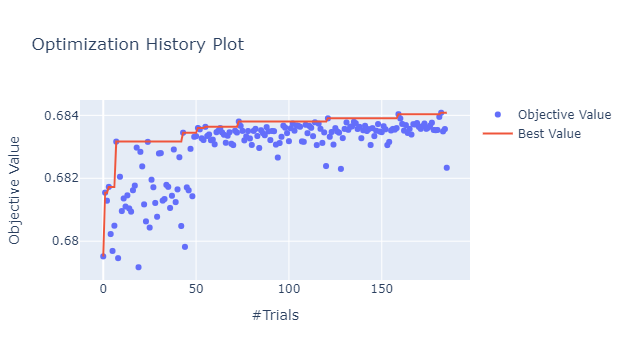

In [17]:
# history
optuna.visualization.plot_optimization_history(study)

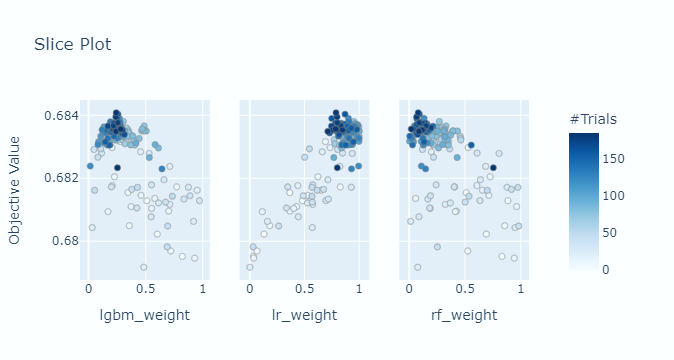

In [18]:
# Visualize individual hyperparameters as slice plot.
optuna.visualization.plot_slice(study)

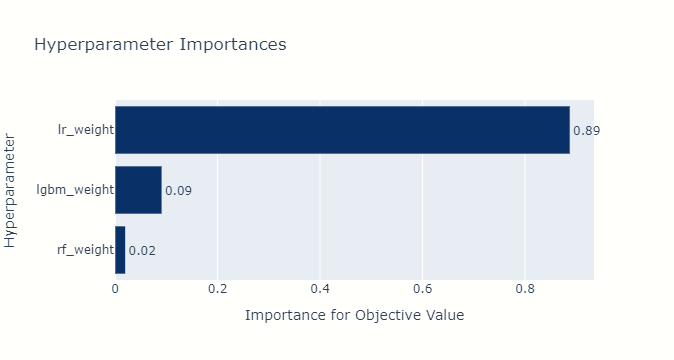

In [19]:
# Visualize parameter importances. 
optuna.visualization.plot_param_importances(study)

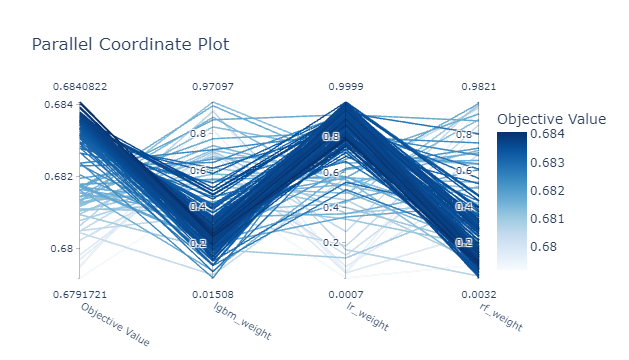

In [20]:
# Space search visualisation
optuna.visualization.plot_parallel_coordinate(study)

## Meilleure solution

In [21]:
# Load best params from last search from file
# study=joblib.load(file_name)
best = study.best_params

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.6840822337521837
  Params: 
    lr_weight: 0.7886277759590068
    rf_weight: 0.0806654784002276
    lgbm_weight: 0.24218477351422812


TRAIN
               precision    recall  f1-score   support

           0       0.96      0.70      0.81    122457
           1       0.17      0.69      0.27     10473

    accuracy                           0.70    132930
   macro avg       0.56      0.70      0.54    132930
weighted avg       0.90      0.70      0.77    132930

 Scores  on train : {'COST': 0.6840822337521837, 'AUC': 0.7460052198900853}
TEST
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     30615
           1       0.16      0.65      0.25      2618

    accuracy                           0.70     33233
   macro avg       0.56      0.68      0.53     33233
weighted avg       0.90      0.70      0.77     33233

 Scores  on test : {'COST': 0.6779602251127167}


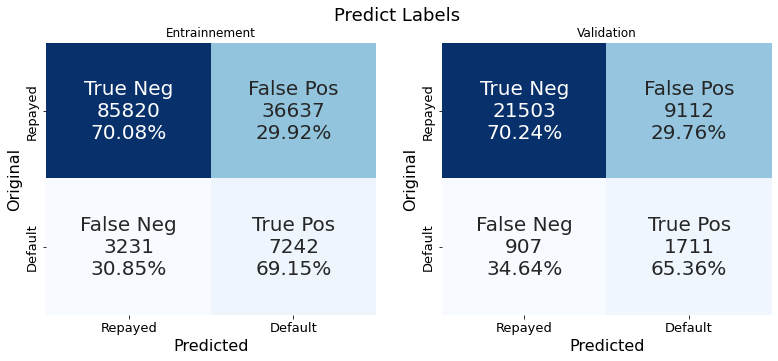

In [22]:
# print best results
# print('Best custom_score = {} for {}'.format(study.best_value,best))

# Initialize params
params = {}

# Logistic regression weight
lr_weight = best['lr_weight']

# Random Forest weight
rf_weight = best['rf_weight']

# LGBM weight
lgbm_weight = best['lgbm_weight']

params['weights'] = [lr_weight, rf_weight, lgbm_weight]
    
# set and fit with best params
voting.set_params(**params)
voting.fit(train, train_true)

# print evaluation summary
evaluate_estimator(voting,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv)#,
#                    log=(LOG,run,'Modele/[Optimisation]/'))

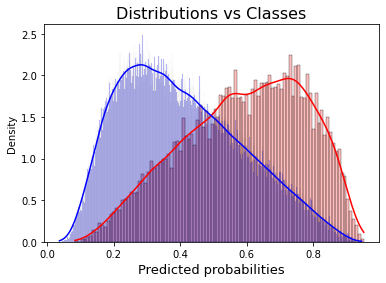

In [23]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = voting.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Optimisation]/Train'))

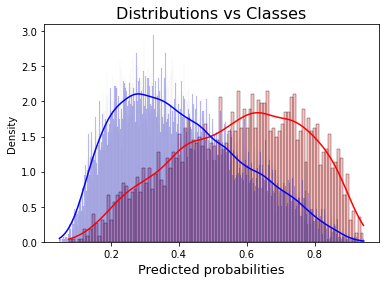

In [24]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = voting.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Optimisation]/Test'))

In [25]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv_box = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_validate(model,
                            X,
                            y,
                            scoring=SCORER,
                            cv=cv_box,
                            n_jobs=-1,
                            error_score='raise',
                            verbose=2)
    return scores

# # evaluate the models and store results
model = clone(voting)
name = 'voting opt'
scores = evaluate_model(model, train, train_true)
cost_scores = scores['test_COST']
fitting_times = scores['fit_time']
test_score = cost(test_true, voting.predict(test))
print('>%s cv cost score mean: %.4f (\u00B1 %.4f) fitted in %.3f s (\u00B1 %.3f s)' % (name,
                                                                                    cost_scores.mean(),
                                                                                    cost_scores.std(),
                                                                                    fitting_times.mean(),
                                                                                    fitting_times.std()
                                                                                   )
     )
train_cv = (cost_scores)
fit_time_cv = (fitting_times)
cost_test = (test_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.4min remaining:   34.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


>voting opt cv cost score mean: 0.6834 (± 0.0050) fitted in 64.914 s (± 20.088 s)


In [26]:
Table_ensemble_stats = joblib.load('Results/all_stats.df')
Table_ensemble_stats = Table_ensemble_stats.append({'Model name'   : name,
                                                    'Cost max'     : train_cv.max(),
                                                    'Cost avr'     : train_cv.mean(),
                                                    'Cost min'     : train_cv.min(),
                                                    'Fit time max' : fit_time_cv.max(),
                                                    'Fit time avr' : fit_time_cv.mean(),
                                                    'Fit time min' : fit_time_cv.min(),
                                                    'Cost on test' : cost_test,
                                                   }, ignore_index=True)

Table_ensemble_stats.style.highlight_max()

,Model name,Cost max,Cost avr,Cost min,Fit time max,Fit time avr,Fit time min,Cost on test
0,lr,0.690014,0.682146,0.677287,7.029810,6.485652,5.851279,0.676767
1,rf,0.680991,0.677305,0.673058,23.517204,23.416173,23.286650,0.669508
2,lgbm,0.685748,0.679020,0.672259,21.239125,20.026438,17.662413,0.672634
3,voting,0.690058,0.681468,0.675021,49.934530,49.383652,48.693325,0.675663
4,voting opt,0.691717,0.683358,0.675835,75.703902,64.913773,24.334318,0.677960


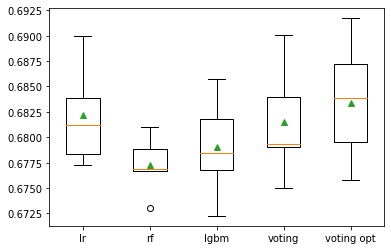

In [27]:
# load results from evaluation in Ensemble Voting out of bag notebook
results_cv = joblib.load('Results/results.array')
# append stats of voting optimized
results_cv.append(train_cv)
# plot model performance for comparison
plt.boxplot(results_cv, labels=Table_ensemble_stats['Model name'], showmeans=True)
plt.show()

In [28]:
joblib.dump(Table_ensemble_stats, 'Results/all_stats_final.df')
joblib.dump(results_cv, 'Results/results_final.array')
if LOG:
    run['Table_ensemble_stats'] = Table_ensemble_stats
    run['Table_ensemble_stats_file'].upload('Results/all_stats_final.df')
    
    

## Sauvegarde du modèle pour dasboard

modèle fitté sur toutes les données disponibles

In [29]:
# Set the filename
save_path = 'Models/'
name= 'voting_optimized_fitted'
file_name = name+'.mod'

# Fit on whole datas
voting.fit(features.drop('TARGET', axis=1), features.TARGET)

# Write on disk
joblib.dump(voting, save_path+file_name, compress=3) #('lzma',3))
if LOG:
    run['Best fitted model on all features jobilb'].upload(File(save_path+file_name))
#     run['Best model fitted on all features pickle'].upload(File.as_pickle(file_named))

In [30]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
